In [1]:
import pickle
import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import pickle
import cv2
import skimage.io

import matplotlib.cm 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPooling2D, Input, InputLayer, Reshape
from keras.callbacks import EarlyStopping
from keras.metrics import binary_accuracy
from keras.utils import plot_model
from keras import backend as K

from tqdm import tqdm_notebook as tqdm


import sys

#get GPU running !
config = tf.ConfigProto()
config.gpu_options.allow_growth = False
sess = tf.Session(config=config)
keras.backend.set_session(sess)

import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.WARN)

Using TensorFlow backend.


In [2]:
def get_images_fct(DATA_PATH,IMAGE_PATH,PATH, df_data):
    '''
    Returns a list of images
    '''
    PATH = DATA_PATH+IMAGE_PATH+PATH
    im_names = df_data.filename.unique()
    filenames = [os.path.join(PATH, name) + '.jpg' for name in im_names]
    images = skimage.io.imread_collection(filenames)
    print('Number of images: ', len(images))
    return images

In [3]:
dataset_path= './Data/images/'

# Load images
DATA_PATH = './Data'#"../../project-data"
IMAGE_PATH = "/images"
TRAIN_PATH = "/train"
TEST_PATH = "/test"
VALIDATION_PATH = "/validation"

train_data = pd.read_pickle("df_train.pickle")
test_data = pd.read_pickle("df_test.pickle")
val_data = pd.read_pickle("df_val.pickle")

train_images = get_images_fct(DATA_PATH,IMAGE_PATH, TRAIN_PATH, train_data)
test_images = get_images_fct(DATA_PATH,IMAGE_PATH, TEST_PATH, test_data)
val_images = get_images_fct(DATA_PATH,IMAGE_PATH, VALIDATION_PATH, val_data)

Number of images:  532
Number of images:  33
Number of images:  103


## Model

In [4]:
target_size=(40,40)

In [5]:
model = Sequential()

#feature extraction part
model.add(Conv2D(input_shape=(target_size[0],target_size[1], 3), filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#classification part
_,b,c,d=model.output_shape #hardcode the reshape for cv.dnn issues
model.add(Reshape(target_shape=[b*c*d])) 
model.add(Dense(64, activation='selu'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
model.load_weights('Cnn.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxP

### Sliding window

In [6]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [7]:
def draw_rect(df,img_idx, ax):
    """
    ...
    """
    i=df[df['filename']==df.loc[img_idx,'filename']]
   
    for j in i.index:
            rect = patches.Rectangle((i.iloc[j,1], i.iloc[j,2]),
                                     i.iloc[j,3]-i.iloc[j,1],
                                     i.iloc[j,4]-i.iloc[j,2],
                        linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
    return ax

In [8]:
with open('df_train.pickle', 'rb') as handle:
    df_train = pickle.load(handle)

In [9]:
df_train.head()

,filename,xmin,ymin,xmax,ymax
0,59023fbd579e52581ddede9f_32.00px_19,915.0,121.0,961.0,167.0
1,59023fbd579e52581ddede9f_32.00px_19,161.0,619.0,206.0,665.0
2,59023fbd579e52581ddede9f_32.00px_19,339.0,532.0,384.0,578.0
3,59023fbd579e52581ddede9f_32.00px_19,727.0,743.0,773.0,789.0
4,59023fbd579e52581ddede9f_32.00px_19,851.0,650.0,897.0,696.0


In [10]:
def normalise_colors_values(image):
    '''
    nomalizes images distribution across RGB channels to match target and returns the normalized image
    '''
    
    new_im = np.ones_like(image).astype(float)
    target=[236.8, 240.36, 238.6]
    
    for i in range(3):
        mean = image[:,:,i].mean()
        new_im[:,:,i] = (target[i]/mean) * image[:,:,i]
        new_im = new_im.astype(int)
        new_im[new_im > 255] = 255
    return new_im

In [11]:
#Size of the sliding windows (a bit bigger than a varroa which is approximately a square of 32x32)
(winW, winH) = (40, 40)
overlap=20
img=cv2.imread(DATA_PATH+'/images/train/'+df_train.loc[0, 'filename']+'.jpg')

#Train images processing
probas=np.float32(np.zeros_like(img[:,:,0]))
mask=np.float32(np.zeros_like(img[:,:,0])) #how many time a pixels gets updates

# loop over the sliding window
for (x, y, window) in sliding_window(img, stepSize=overlap, windowSize=(winW, winH)):
    
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue
    else:
        window=normalise_colors_values(window)
        window=window[np.newaxis, ...]
        probas[y:y+overlap,x:x+overlap] = probas[y:y+overlap,x:x+overlap] + model.predict_proba(window)[0][0]
        mask[y:y+overlap,x:x+overlap] +=  mask[y:y+overlap,x:x+overlap] + 1

probas=probas/mask #get the mean of the predictions for each pixel



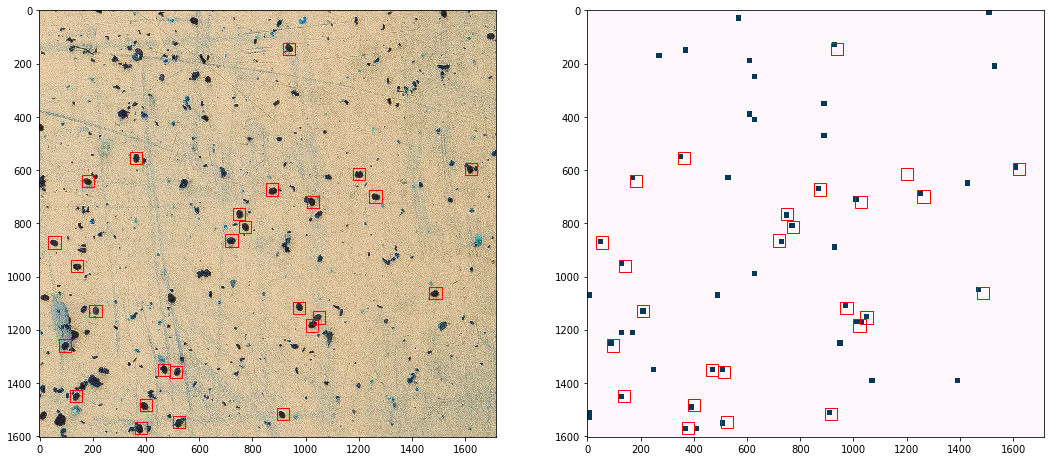

In [12]:
fig, ax =plt.subplots(1,2,figsize=(18,10))
ax[0].imshow(img)
ax[0]=draw_rect(df_train, 0, ax[0])
thresh=0.8
ax[1].imshow(np.ma.masked_where(probas > 0.99, probas).mask, cmap='PuBu')
ax[1]=draw_rect(df_train, 0, ax[1])
#plt.colorbar(a, fraction=0.0445, pad=0)
plt.show()

In [13]:
def binarize_matrix (matrix, thresh):
    indices = matrix<thresh
    matrix[indices] = 0
    indices = matrix >= thresh
    matrix[indices] = 1
    indices = np.isnan(matrix)
    matrix[indices] = 0
    return matrix

In [15]:
def computeBboxCoord(labelled_img):
    
    num_comp = np.max(labelled_img)
    center = np.zeros((num_comp,2))
    bbox_coord = np.zeros((num_comp, 4))
    
    for i in range(num_comp):
        coord = labelled_img==(i+1)
        im_h, im_w = coord.shape
        listx = []
        listy = []
        for y in range(im_h):
            for x in range(im_w):
                if(coord[y,x] and x not in listx and y not in listy):
                    listx.append(x)
                    listy.append(y)
        x_center = np.mean(listx)
        y_center = np.mean(listy)
        center[i,1] = y_center
        center[i,0] = x_center
        
        bbox_coord[i][0] = np.min(listx) #xmin
        bbox_coord[i][1] = np.min(listy) #ymin
        bbox_coord[i][2] = np.max(listx) #xmax
        bbox_coord[i][3] = np.max(listy) #ymax
    return bbox_coord 

In [31]:
def draw_rectangle_simplified (varroNbr, bbox_coord, ax, margin):
    for i in range(varroNbr):
            rect = patches.Rectangle((bbox_coord[i][0]-(bbox_coord[i][2]-bbox_coord[i][0])*margin/2, 
                                      bbox_coord[i][1]-(bbox_coord[i][3]-bbox_coord[i][1])*margin/2), 
                                     (bbox_coord[i][2]-bbox_coord[i][0])*(1+margin), 
                                     (bbox_coord[i][3]-bbox_coord[i][1])*(1+margin), 
                                     linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

In [16]:
thresh = 0.99
probas_binarize = probas.copy()
probas_binarize = binarize_matrix(probas_binarize, thresh)

varroa_labeled = skimage.measure.label(probas_binarize)
bbox_coord = computeBboxCoord(varroa_labeled) #center contains the y and x center value

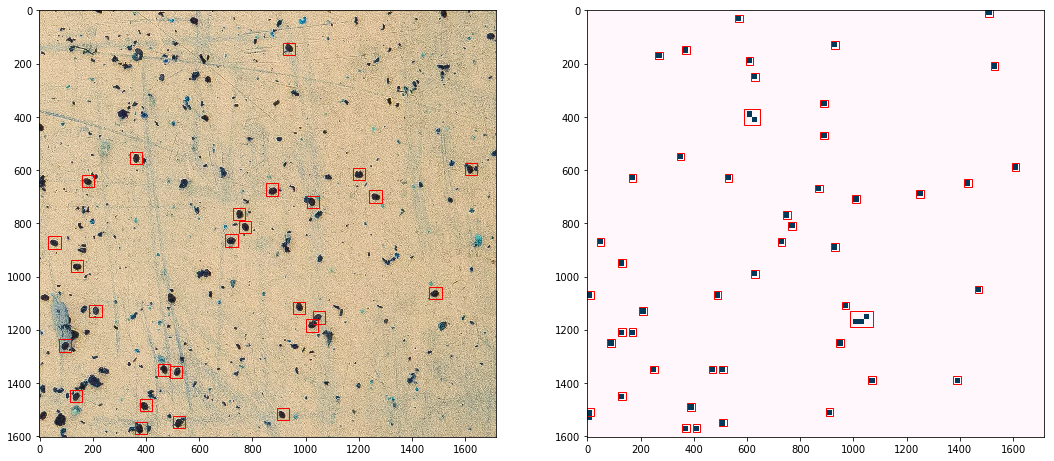

In [32]:
margin = 0.5

fig, ax =plt.subplots(1,2,figsize=(18,10))
ax[0].imshow(img)
ax[0]=draw_rect(df_train, 0, ax[0])

ax[1].imshow(np.ma.masked_where(probas > thresh, probas).mask, cmap='PuBu')
ax[1] = draw_rectangle_simplified (np.max(varroa_labeled), bbox_coord, ax[1], margin)
#plt.colorbar(a, fraction=0.0445, pad=0)
plt.show()

In [36]:
def bb_intersection_over_union(boxA, boxB):
    '''
    Given two bounding boxex, calculates IoU
    
    args:
    boxA (int,int,int,int) : (ymin, xmin, ymax, xmax)
    boxB (int,int,int,int) : (ymin, xmin, ymax, xmax)
    
    output:
    IoU (float) : IoU of boxA and boxB
    
    credits to Adrian Rosebrock : https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    '''
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        
    if interArea > 0:
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # return the intersection over union value
    else :
        iou = 0
        
    return iou

In [37]:
def IoU_bbox(detected, ground_truth):
    '''
    Creates a matrix with rows corresponding to the detected objects and the columns 
    corresponding to the ground_truth. The i,j element of the matrix correspond to the IoU
    score between the detected box i and the gorund truth j.
    An additional column is added (last position) to represent the detect boxes that
    do not match any ground truth (their score is -1)
    An additional row is added (last position) correponding to the ground-truth that 
    do not intersect with any detected ones (their score is -2).
    
    args:
    detected : detected boxes
    ground_truth : the ground_truth boxes.
    
    returns:
    matrix of IoU scores.
    '''
    nb_detected = len(detected)
    nb_true = len(ground_truth)
    iou_matrix = np.zeros((nb_detected+1, nb_true+1))



    #for each detected box, go over all true boxes
    for i in range(nb_detected) :
        
        detected_box = image_detected[i]
        
        for j in range(nb_true):  
            region = image_true[j]

            #modyfying bbox of true to satisfy bbox format or regionprop
            bbox_modified = (region['bbox'][1], region['bbox'][0], \
                            region['bbox'][1] + region['bbox'][3], \
                            region['bbox'][0] + region['bbox'][2])
            #calculates IoU
            iou = bb_intersection_over_union(detected_box.bbox, bbox_modified)
            
            iou_matrix[i,j] = iou
            
        
        #last column is -1: detected but not ground-truth : false positives    
        #if iou_matrix.sum(axis=1)[i] == 0:
        if sum(iou_matrix[i,:])==0:
            iou_matrix[i,j+1] = -1
    
    #last row is -2: ground-truth but not detected: false negative       
    iou_matrix[-1, [iou_matrix.sum(axis=0) == 0][0]] = -2
    
    #element at 'false postive' and 'false negative' column intersection
    iou_matrix[-1,-1] = 0
    
    return iou_matrix


In [ ]:
matrices = []
#computes the IoU score for every box in each image.
for image_detected, image_true in zip(region_img, annotations_xmls):
    matrices.append(IoU_bbox(image_detected, image_true))